In [25]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import backend as K
from keras.models import Sequential
from keras.layers import Input, Dropout, Dense, MaxPool2D, MaxPooling2D
from keras.layers import Flatten, BatchNormalization, Conv2D
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD
from PIL import Image
from sklearn.metrics import fbeta_score
from sklearn.model_selection import train_test_split
import cv2
import os
from tqdm import tqdm

In [26]:
!ls ../input/planets-dataset/planet/planet

sample_submission.csv  test-jpg  train-jpg  train_classes.csv


In [27]:
path = "../input/planets-dataset/planet/planet/"
train_path = os.path.join(path, "train-jpg")
test_path = os.path.join(path, "test-jpg")
class_path = os.path.join(path, "train_classes.csv")
submission_path = os.path.join(path, "sample_submission.csv")

In [28]:
#reading the labels
data_fr = pd.read_csv(class_path)
subm_df = pd.read_csv(submission_path)

print(data_fr.shape)
print(subm_df.shape)

(40479, 2)
(61191, 2)


In [29]:
label_list = []
for t_split in data_fr.tags.to_numpy():
    labels = t_split.split(' ')
    for i in labels:
        if i not in label_list:
            label_list.append(i)

In [30]:
print(len(label_list))

17


In [31]:
labels_dict = dict(zip(range(0,17), label_list))
labels_dict

{0: 'haze',
 1: 'primary',
 2: 'agriculture',
 3: 'clear',
 4: 'water',
 5: 'habitation',
 6: 'road',
 7: 'cultivation',
 8: 'slash_burn',
 9: 'cloudy',
 10: 'partly_cloudy',
 11: 'conventional_mine',
 12: 'bare_ground',
 13: 'artisinal_mine',
 14: 'blooming',
 15: 'selective_logging',
 16: 'blow_down'}

In [32]:
# One-hot encode the features
for i in label_list:
    data_fr[i] = data_fr['tags'].apply(lambda x: 1 if i in x.split() else 0)
    
data_fr.head(10)

,image_name,tags,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
0,train_0,haze primary,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,train_1,agriculture clear primary water,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,train_2,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,train_3,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,train_4,agriculture clear habitation primary road,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0
5,train_5,haze primary water,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
6,train_6,agriculture clear cultivation primary water,0,1,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0
7,train_7,haze primary,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,train_8,agriculture clear cultivation primary,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0
9,train_9,agriculture clear cultivation primary road,0,1,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0


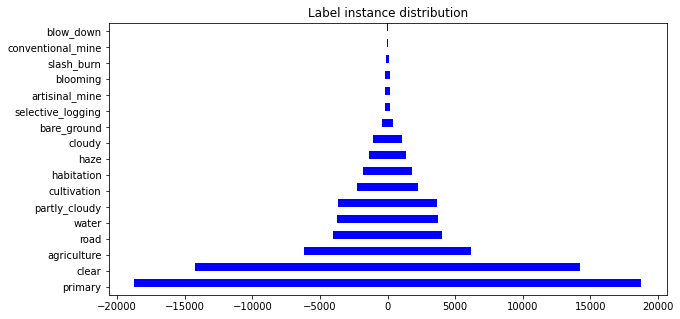

In [33]:
# plot the labels      
data_fr[label_list].sum().sort_values(ascending=False)\
.plot(kind='barh', title='Label instance distribution', \
      orientation= 'vertical', figsize=(10, 5), color='blue')
plt.show()

In [34]:
import gc
gc.collect()

4872

In [35]:
# for the analysis we need columns after tag and image_name
data_fr_columns = list(data_fr.columns[2:])
print(data_fr_columns,end='')

['haze', 'primary', 'agriculture', 'clear', 'water', 'habitation', 'road', 'cultivation', 'slash_burn', 'cloudy', 'partly_cloudy', 'conventional_mine', 'bare_ground', 'artisinal_mine', 'blooming', 'selective_logging', 'blow_down']

In [36]:
# Onehot encode the image name
data_fr['image_name'] = data_fr['image_name'].apply(lambda x: f'{x}.jpg')
data_fr.head(5)

,image_name,tags,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
0,train_0.jpg,haze primary,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,train_1.jpg,agriculture clear primary water,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,train_2.jpg,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,train_3.jpg,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,train_4.jpg,agriculture clear habitation primary road,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0


In [37]:
import gc
gc.collect()

23

In [38]:
def fbeta(y_true, y_pred, beta = 2, epsilon = 1e-4):
    
    beta_squared = beta**2
    
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(tf.greater(tf.cast(y_pred, tf.float32), tf.constant(0.5)), tf.float32)
    
    tp = tf.reduce_sum(y_true * y_pred, axis = 1)
    fp = tf.reduce_sum(y_pred, axis = 1) - tp
    fn = tf.reduce_sum(y_true, axis = 1) - tp
    
    precision = tp/(tp +fp +epsilon)
    recall = tp/(tp + fn + epsilon)
    
    return (1 + beta_squared) * precision * recall / (beta_squared * precision + recall + epsilon)


In [39]:
def accuracy_score(y_true, y_pred, epsilon = 1e-4):
    
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(tf.greater(tf.cast(y_pred, tf.float32), tf.constant(0.5)), tf.float32)
    
    tp = tf.reduce_sum(y_true * y_pred, axis = 1)
    fp = tf.reduce_sum(y_pred, axis = 1) - tp
    fn = tf.reduce_sum(y_true, axis = 1) - tp
    
    y_true = tf.cast(y_true, tf.bool)
    y_pred = tf.cast(y_pred, tf.bool)
        
    tn = tf.reduce_sum(tf.cast(tf.logical_not(y_true), tf.float32) * tf.cast(tf.logical_not(y_pred), tf.float32), 
                       axis = 1)
    return (tp + tn)/(tp + tn + fp + fn + epsilon)

In [40]:
train_datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)

# train_set contains 80 percent of images
train_gen = train_datagen.flow_from_dataframe(dataframe=data_fr,
                                              directory = train_path,  
                                              x_col="image_name", 
                                              y_col=data_fr_columns, 
                                              subset="training", 
                                              batch_size=128,
                                              seed=42, 
                                              shuffle = True, 
                                              class_mode="raw", 
                                              target_size=(128,128))


# val_set contains 20 percent of images 
val_gen = train_datagen.flow_from_dataframe(dataframe=data_fr,
                                            directory = train_path,  
                                            x_col="image_name", 
                                            y_col=data_fr_columns, 
                                            subset="validation", 
                                            batch_size=128,
                                            seed=42, 
                                            shuffle = True, 
                                            class_mode="raw", 
                                            target_size=(128,128))

Found 32384 validated image filenames.
Found 8095 validated image filenames.


In [41]:
import gc
gc.collect()

46

In [42]:
def model_building():
    model = Sequential()
    model.add(BatchNormalization(input_shape=(128, 128, 3)))
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(17, activation='sigmoid'))
    
    return model
    

In [43]:
model = model_building()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 128, 128, 3)       12        
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 126, 126, 32)      9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 63, 63, 64)        18496     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 61, 61, 64)       

In [44]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=[fbeta, accuracy_score])

# Save the callback
callback = EarlyStopping(
    monitor="val_loss", 
    patience=2,
    verbose=0,
    baseline=None,
    restore_best_weights=True,
)

In [45]:
# Batchsize for training and validation set
train_steps = train_gen.n // train_gen.batch_size
val_steps = val_gen.n // train_gen.batch_size

In [46]:
import gc
gc.collect()

617

In [47]:
history = model.fit(x=train_gen,
                    steps_per_epoch=train_steps,
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=15,
                    callbacks=[callback]) 

Epoch 1/15
253/253 [==============================] - 110s 433ms/step - loss: 0.2376 - fbeta: 0.6751 - accuracy_score: 0.9094 - val_loss: 0.1980 - val_fbeta: 0.6926 - val_accuracy_score: 0.9222
Epoch 2/15
253/253 [==============================] - 108s 425ms/step - loss: 0.1717 - fbeta: 0.7746 - accuracy_score: 0.9333 - val_loss: 0.1572 - val_fbeta: 0.7867 - val_accuracy_score: 0.9377
Epoch 3/15
253/253 [==============================] - 105s 416ms/step - loss: 0.1520 - fbeta: 0.8006 - accuracy_score: 0.9403 - val_loss: 0.1451 - val_fbeta: 0.8027 - val_accuracy_score: 0.9409
Epoch 4/15
253/253 [==============================] - 105s 416ms/step - loss: 0.1362 - fbeta: 0.8264 - accuracy_score: 0.9464 - val_loss: 0.1253 - val_fbeta: 0.8470 - val_accuracy_score: 0.9516
Epoch 6/15
253/253 [==============================] - 107s 422ms/step - loss: 0.1277 - fbeta: 0.8407 - accuracy_score: 0.9497 - val_loss: 0.1235 - val_fbeta: 0.8377 - val_accuracy_score: 0.9513
Epoch 7/15
253/253 [==========

In [48]:
import gc
gc.collect()

46

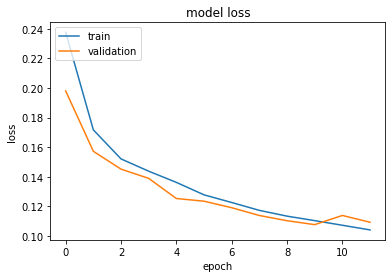

In [49]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [52]:
# Test data: divide the submission dataframe into two splits as the image names after 40669 is different 
test_df = subm_df.iloc[:40669]['image_name'].reset_index().drop('index', axis =1)

In [53]:
test_df['image_name'] = subm_df['image_name'].apply(lambda x: '{}.jpg'.format(x))
test_df.head()

,image_name
0,test_0.jpg
1,test_1.jpg
2,test_2.jpg
3,test_3.jpg
4,test_4.jpg


In [54]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_gen = test_datagen.flow_from_dataframe(dataframe=test_df,
                                            directory = test_path,  
                                            x_col="image_name", 
                                            y_col=None, 
                                            batch_size=67,
                                            shuffle=False,
                                            class_mode=None, 
                                            target_size=(128,128))

test_size = test_gen.n // test_gen.batch_size

Found 40669 validated image filenames.


In [55]:
pred = model.predict(test_gen, steps=test_size, verbose=1)

607/607 [==============================] - 353s 582ms/step


In [56]:
test_names = test_gen.filenames 
        
test_result = pd.DataFrame(pred)
test_result = test_result.apply(lambda x: ' '.join(np.array(label_list)[x >= 0.2]), axis=1)

test_result_df = pd.DataFrame({'image_name': test_names, 'tags': test_result})
test_result_df.head()

,image_name,tags
0,test_0.jpg,primary clear
1,test_1.jpg,primary clear
2,test_2.jpg,primary partly_cloudy
3,test_3.jpg,primary agriculture clear cultivation
4,test_4.jpg,primary cloudy partly_cloudy


In [57]:
# additional batch of the test dataset
additional_df = subm_df.iloc[40669:]['image_name'].reset_index().drop('index', axis=1)

In [58]:
additional_df['image_name'] = additional_df['image_name'].apply(lambda x: '{}.jpg'.format(x))
additional_df.head()

,image_name
0,file_0.jpg
1,file_1.jpg
2,file_10.jpg
3,file_100.jpg
4,file_1000.jpg


In [59]:
additional_gen = test_datagen.flow_from_dataframe(dataframe=additional_df,
                                                  directory="../input/planets-dataset/test-jpg-additional/test-jpg-additional", 
                                                  x_col='image_name',
                                                  y_col = None,
                                                  batch_size=62,
                                                  shuffle=False,
                                                  class_mode=None, 
                                                  target_size=(128, 128))


additional_step = additional_gen.n // additional_gen.batch_size

Found 20522 validated image filenames.


In [61]:
# predicted probabilities for each class
pred_additional = model.predict(additional_gen, steps=additional_step, verbose=1)

331/331 [==============================] - 51s 155ms/step


In [62]:
additional_names = additional_gen.filenames 
        
additional_result = pd.DataFrame(pred_additional)
additional_result = additional_result.apply(lambda x: ' '.join(np.array(label_list)[x >= 0.2]), axis=1)

additional_result_df = pd.DataFrame({'image_name': additional_names, 'tags': additional_result})
additional_result_df.head()

,image_name,tags
0,file_0.jpg,primary clear
1,file_1.jpg,primary agriculture clear habitation road cult...
2,file_10.jpg,haze primary agriculture clear water road
3,file_100.jpg,primary agriculture clear water
4,file_1000.jpg,primary clear


In [63]:
final_result = pd.concat([test_result_df, additional_result_df])

final_result = final_result.reset_index().drop('index', axis =1)

final_result

,image_name,tags
0,test_0.jpg,primary clear
1,test_1.jpg,primary clear
2,test_2.jpg,primary partly_cloudy
3,test_3.jpg,primary agriculture clear cultivation
4,test_4.jpg,primary cloudy partly_cloudy
...,...,...
61186,file_9995.jpg,primary cloudy partly_cloudy
61187,file_9996.jpg,primary agriculture clear water habitation roa...
61188,file_9997.jpg,primary clear water road
61189,file_9998.jpg,cloudy


In [64]:
# Remove the .jpg extension from the image_name of the final_result
final_result['image_name'] = final_result['image_name'].apply(lambda x: x[:-4])
final_result

,image_name,tags
0,test_0,primary clear
1,test_1,primary clear
2,test_2,primary partly_cloudy
3,test_3,primary agriculture clear cultivation
4,test_4,primary cloudy partly_cloudy
...,...,...
61186,file_9995,primary cloudy partly_cloudy
61187,file_9996,primary agriculture clear water habitation roa...
61188,file_9997,primary clear water road
61189,file_9998,cloudy


In [67]:
# save the results to a CSV file save and set the index to false.
final_result.to_csv('submission.csv', index=False)